In [30]:
library(httr)
library(jsonlite)
library(tidyverse)
library(patchwork)

In [2]:
url="https://api.github.com/repos/numpy/numpy/stats/contributors"
res = GET(url)

In [3]:
data = fromJSON(rawToChar(res$content))

In [4]:
names(data)

[1] "total"  "weeks"  "author"

In [5]:
print(data$total)

 [1]   18   56  797   20   25   29   18  127   25   30   17   33  168   16   17
[16]   28  246   24   28   58  134   16   28   96  129   18  110   19   15   24
[31]  217   64   32   29  719   63   45   37   21  517   25   23 1094   50   18
[46]   79   48  159 2095 1472   18   49   15   24  805   72  459   87  167   16
[61]   34   20  132  127   46 1021   21   20   57  971  100   34   16  483   81
[76]   17  179  574  134 2010   47   66  158   39  153   53   26   23   23   18
[91]   24   49   22   58   21   37   42  229


In [6]:
author<-data$author
index_data<-which(author$login=='mattip')

In [7]:
data$total[index_data]

[1] 797

In [8]:
data_weeks<-data$weeks
current_user<-data_weeks[[index_data]]

In [9]:
library(anytime)
current_user$w<-anydate(current_user$w)

Warning message:
"package 'anytime' was built under R version 4.1.2"


In [10]:
adds_per_user <- function(current_user) {
  df_adds<-current_user%>%group_by(w)%>%summarise(adds=sum(a))%>%arrange(desc(w))
  return(df_adds)
}

In [11]:
adds_per_user(current_user)

w,adds
<date>,<int>
2022-02-12,25
2022-02-05,1
2022-01-29,190
2022-01-22,91
2022-01-15,3
2022-01-08,0
2022-01-01,3
2021-12-25,0
2021-12-18,2


In [12]:
adds_per_user_viz<-function(current_user){
options(repr.plot.width=16, repr.plot.height=8)
p <- ggplot(adds_per_user(current_user), aes(x=w, y=adds)) +
  geom_line(color="green3", size=0.8) + 
  xlab("Year")+ylab("Adds") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold")) 
p}

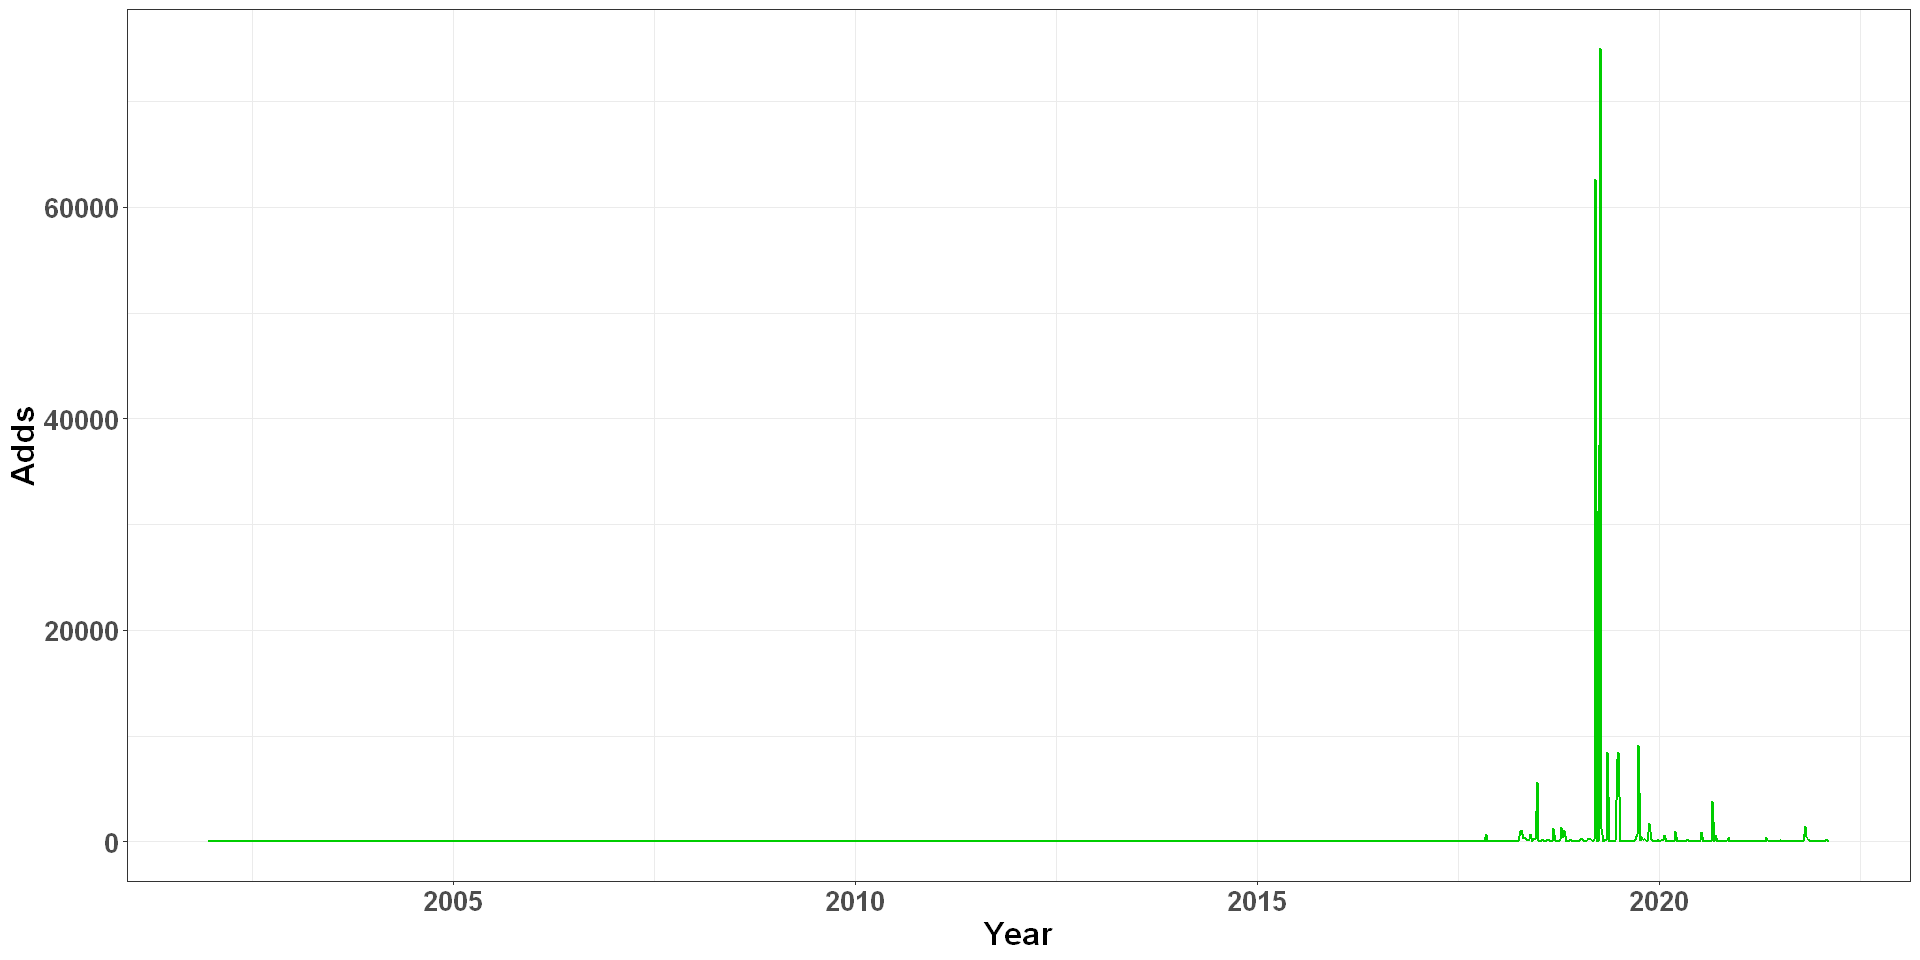

In [13]:
adds_per_user_viz(current_user)

In [14]:
deletes_per_user <- function(current_user) {
  df_deletes<-current_user%>%group_by(w)%>%summarise(deletes=sum(d))%>%arrange(desc(w))
  return(df_deletes)
}

In [15]:
deletes_per_user(current_user)

w,deletes
<date>,<int>
2022-02-12,24
2022-02-05,1
2022-01-29,52
2022-01-22,40
2022-01-15,2
2022-01-08,0
2022-01-01,3
2021-12-25,0
2021-12-18,1


In [16]:
deletes_per_user_viz<-function(current_user){
options(repr.plot.width=16, repr.plot.height=8)
p <- ggplot(deletes_per_user(current_user), aes(x=w, y=deletes)) +
  geom_line(color="royalblue3", size=0.8) + 
  xlab("Year")+ylab("Deletes") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))
p}

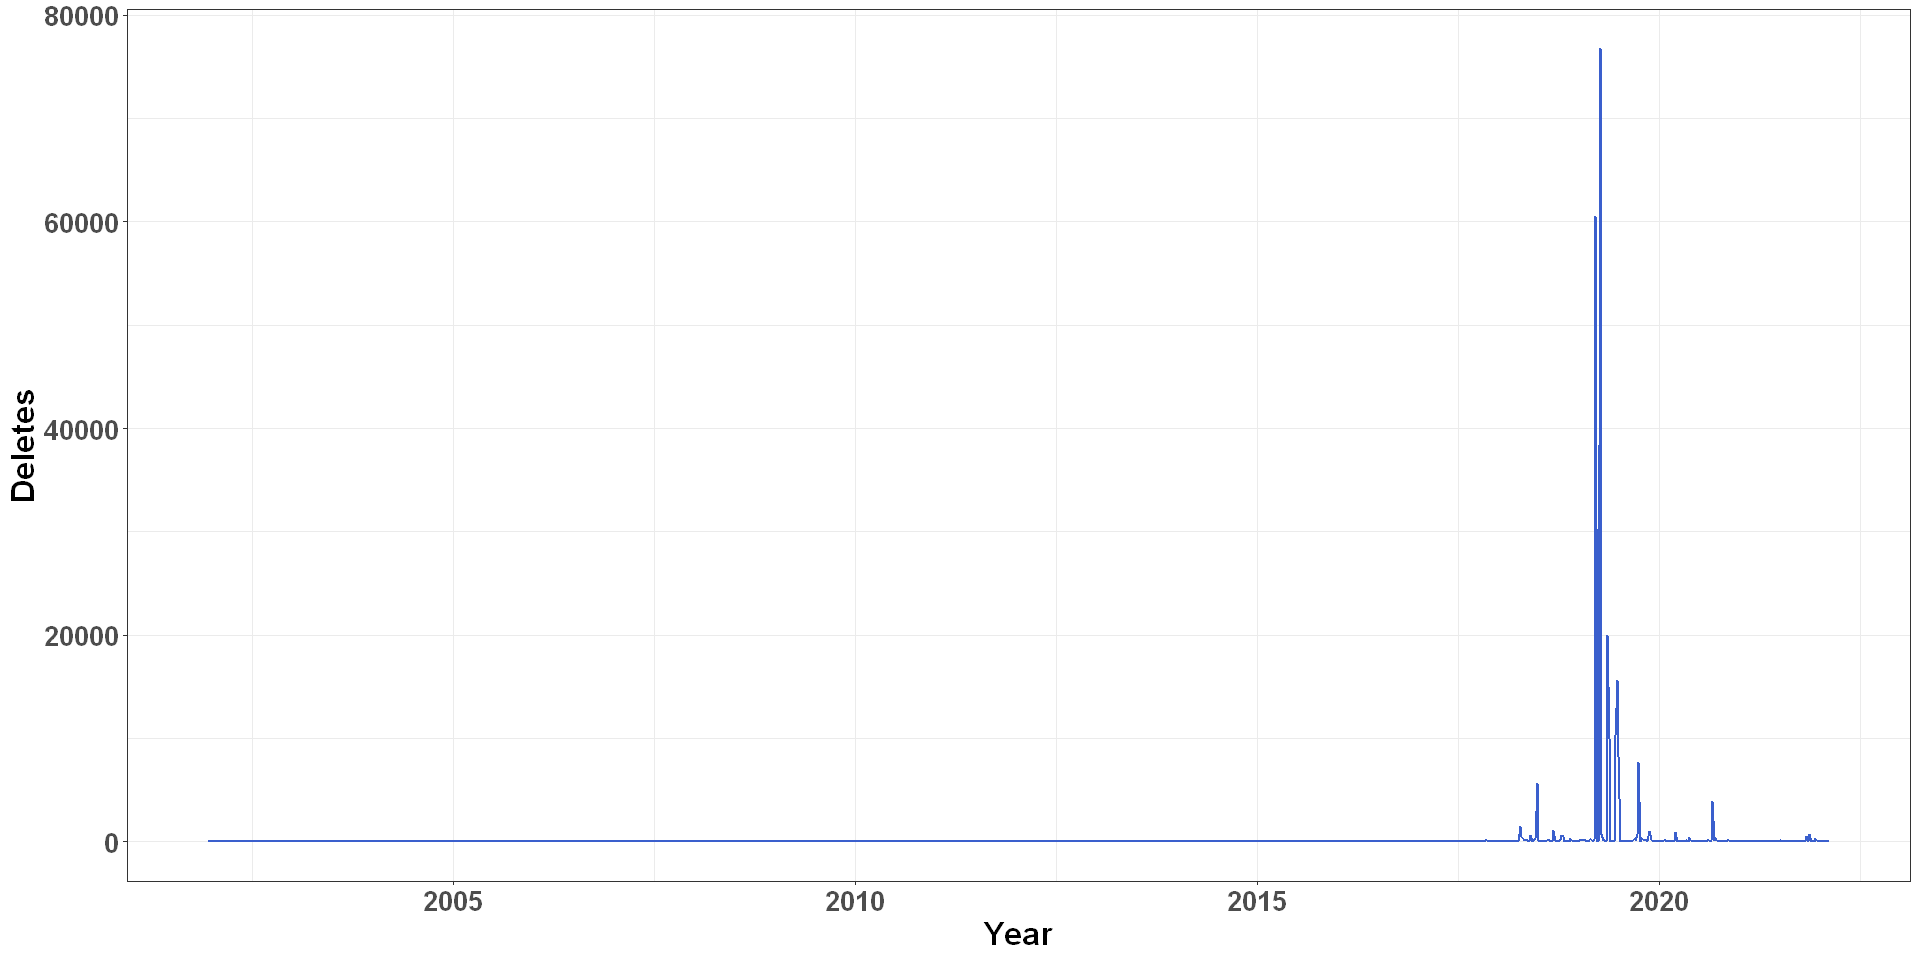

In [17]:
deletes_per_user_viz(current_user)

In [18]:
commits_per_user <- function(current_user) {
  df_commits<-current_user%>%group_by(w)%>%summarise(commits=sum(c))%>%arrange(desc(w))
  return(df_commits)
}

In [19]:
commits_per_user(current_user)

w,commits
<date>,<int>
2022-02-12,5
2022-02-05,1
2022-01-29,5
2022-01-22,11
2022-01-15,1
2022-01-08,0
2022-01-01,1
2021-12-25,0
2021-12-18,1


In [20]:
commits_per_user_viz<-function(current_user){
options(repr.plot.width=16, repr.plot.height=8)
p <- ggplot(commits_per_user(current_user), aes(x=w, y=commits)) +
  geom_line(color="magenta3", size=0.8) + 
  xlab("Year")+ylab("Commits") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))
p}

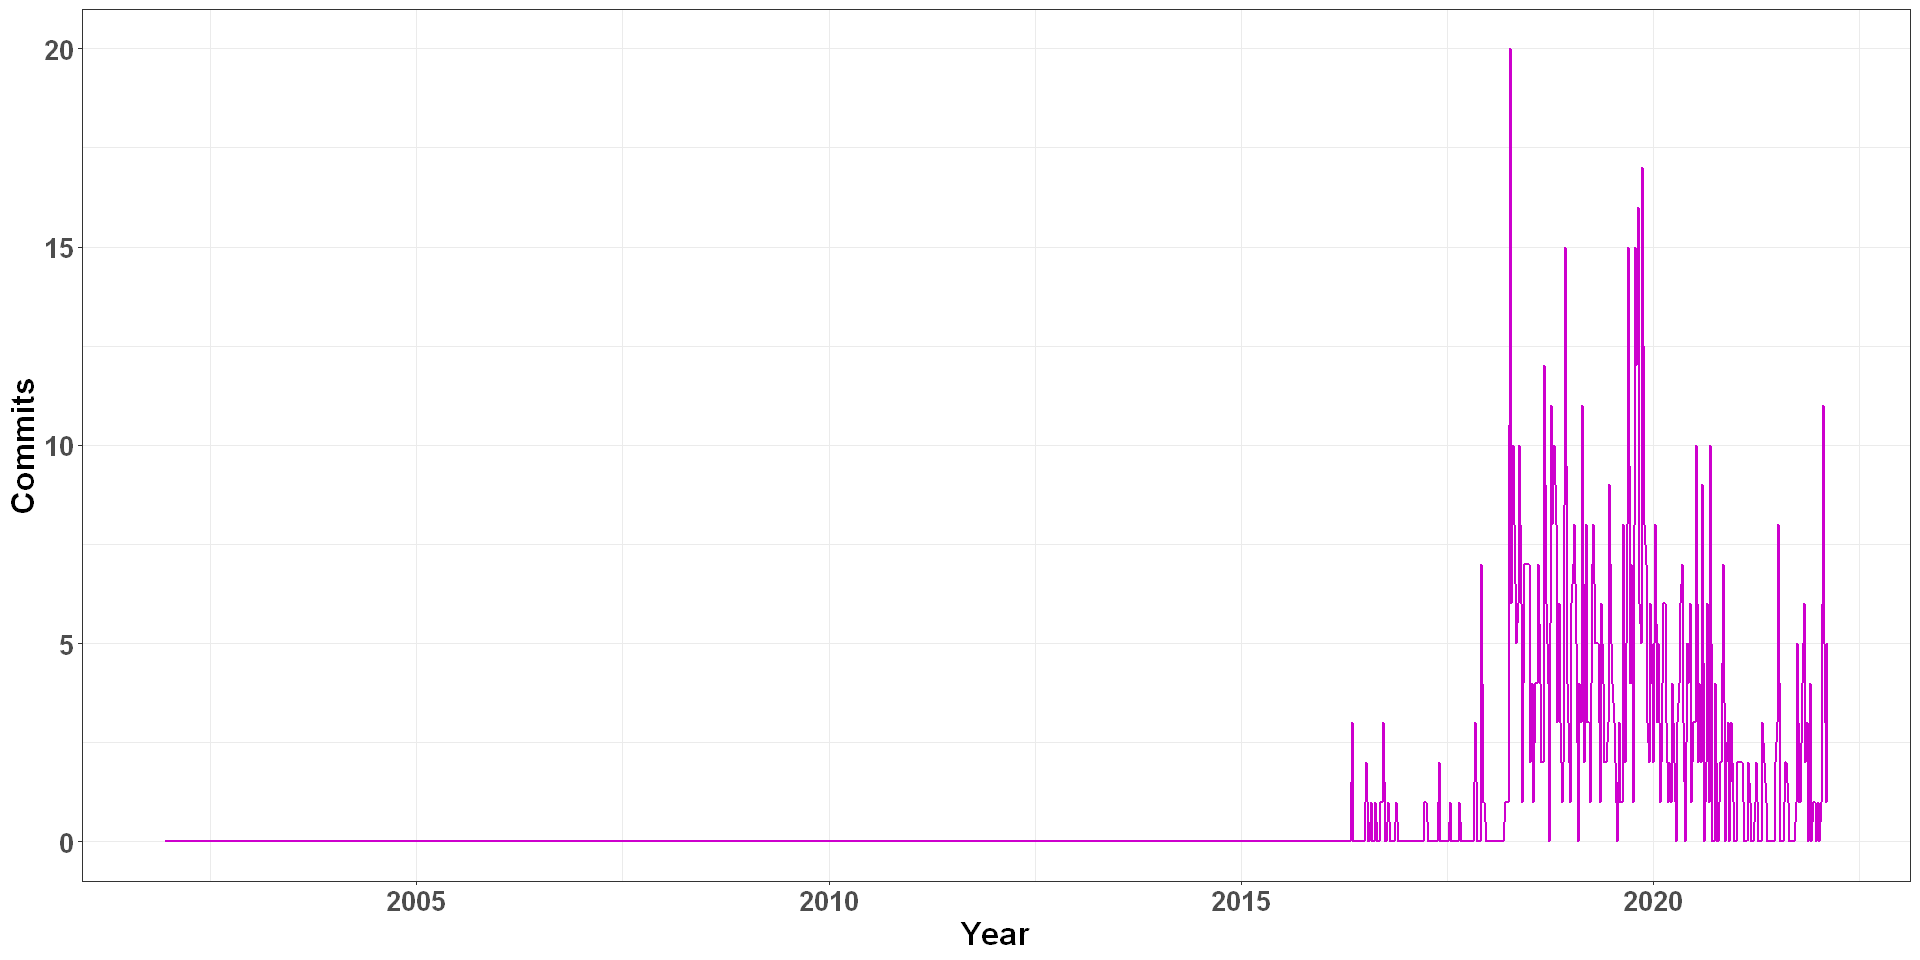

In [21]:
commits_per_user_viz(current_user)

In [22]:
df_contributions<-data$total[index_data]

In [23]:
df_contributions

[1] 797

In [27]:
everything_per_user <- function(current_user) {
  df_commits<-current_user%>%group_by(w)%>%summarise(commits=sum(c), additions=sum(a), deletions=sum(d))%>%arrange(desc(w))
  return(df_commits)
}

In [28]:
everything_per_user(current_user)

w,commits,additions,deletions
<date>,<int>,<int>,<int>
2022-02-12,5,25,24
2022-02-05,1,1,1
2022-01-29,5,190,52
2022-01-22,11,91,40
2022-01-15,1,3,2
2022-01-08,0,0,0
2022-01-01,1,3,3
2021-12-25,0,0,0
2021-12-18,1,2,1


In [38]:
everything_per_user_viz<-function(current_user){
options(repr.plot.width=16, repr.plot.height=8)
pc <- ggplot(commits_per_user(current_user), aes(x=w, y=commits)) +
  geom_line(color="magenta3", size=0.8) + 
  xlab("Year")+ylab("Commits") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))
    
pd <- ggplot(deletes_per_user(current_user), aes(x=w, y=deletes)) +
  geom_line(color="royalblue3", size=0.8) + 
  xlab("Year")+ylab("Deletes") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))    
    
pa <- ggplot(adds_per_user(current_user), aes(x=w, y=adds)) +
  geom_line(color="green3", size=0.8) + 
  xlab("Year")+ylab("Adds") + theme_bw() + theme(axis.text=element_text(size=16, face="bold"),
                axis.title=element_text(size=19,face="bold"))     

options(repr.plot.width=13, repr.plot.height=15)    
pe <- (pa / pd / pc)

pe
}

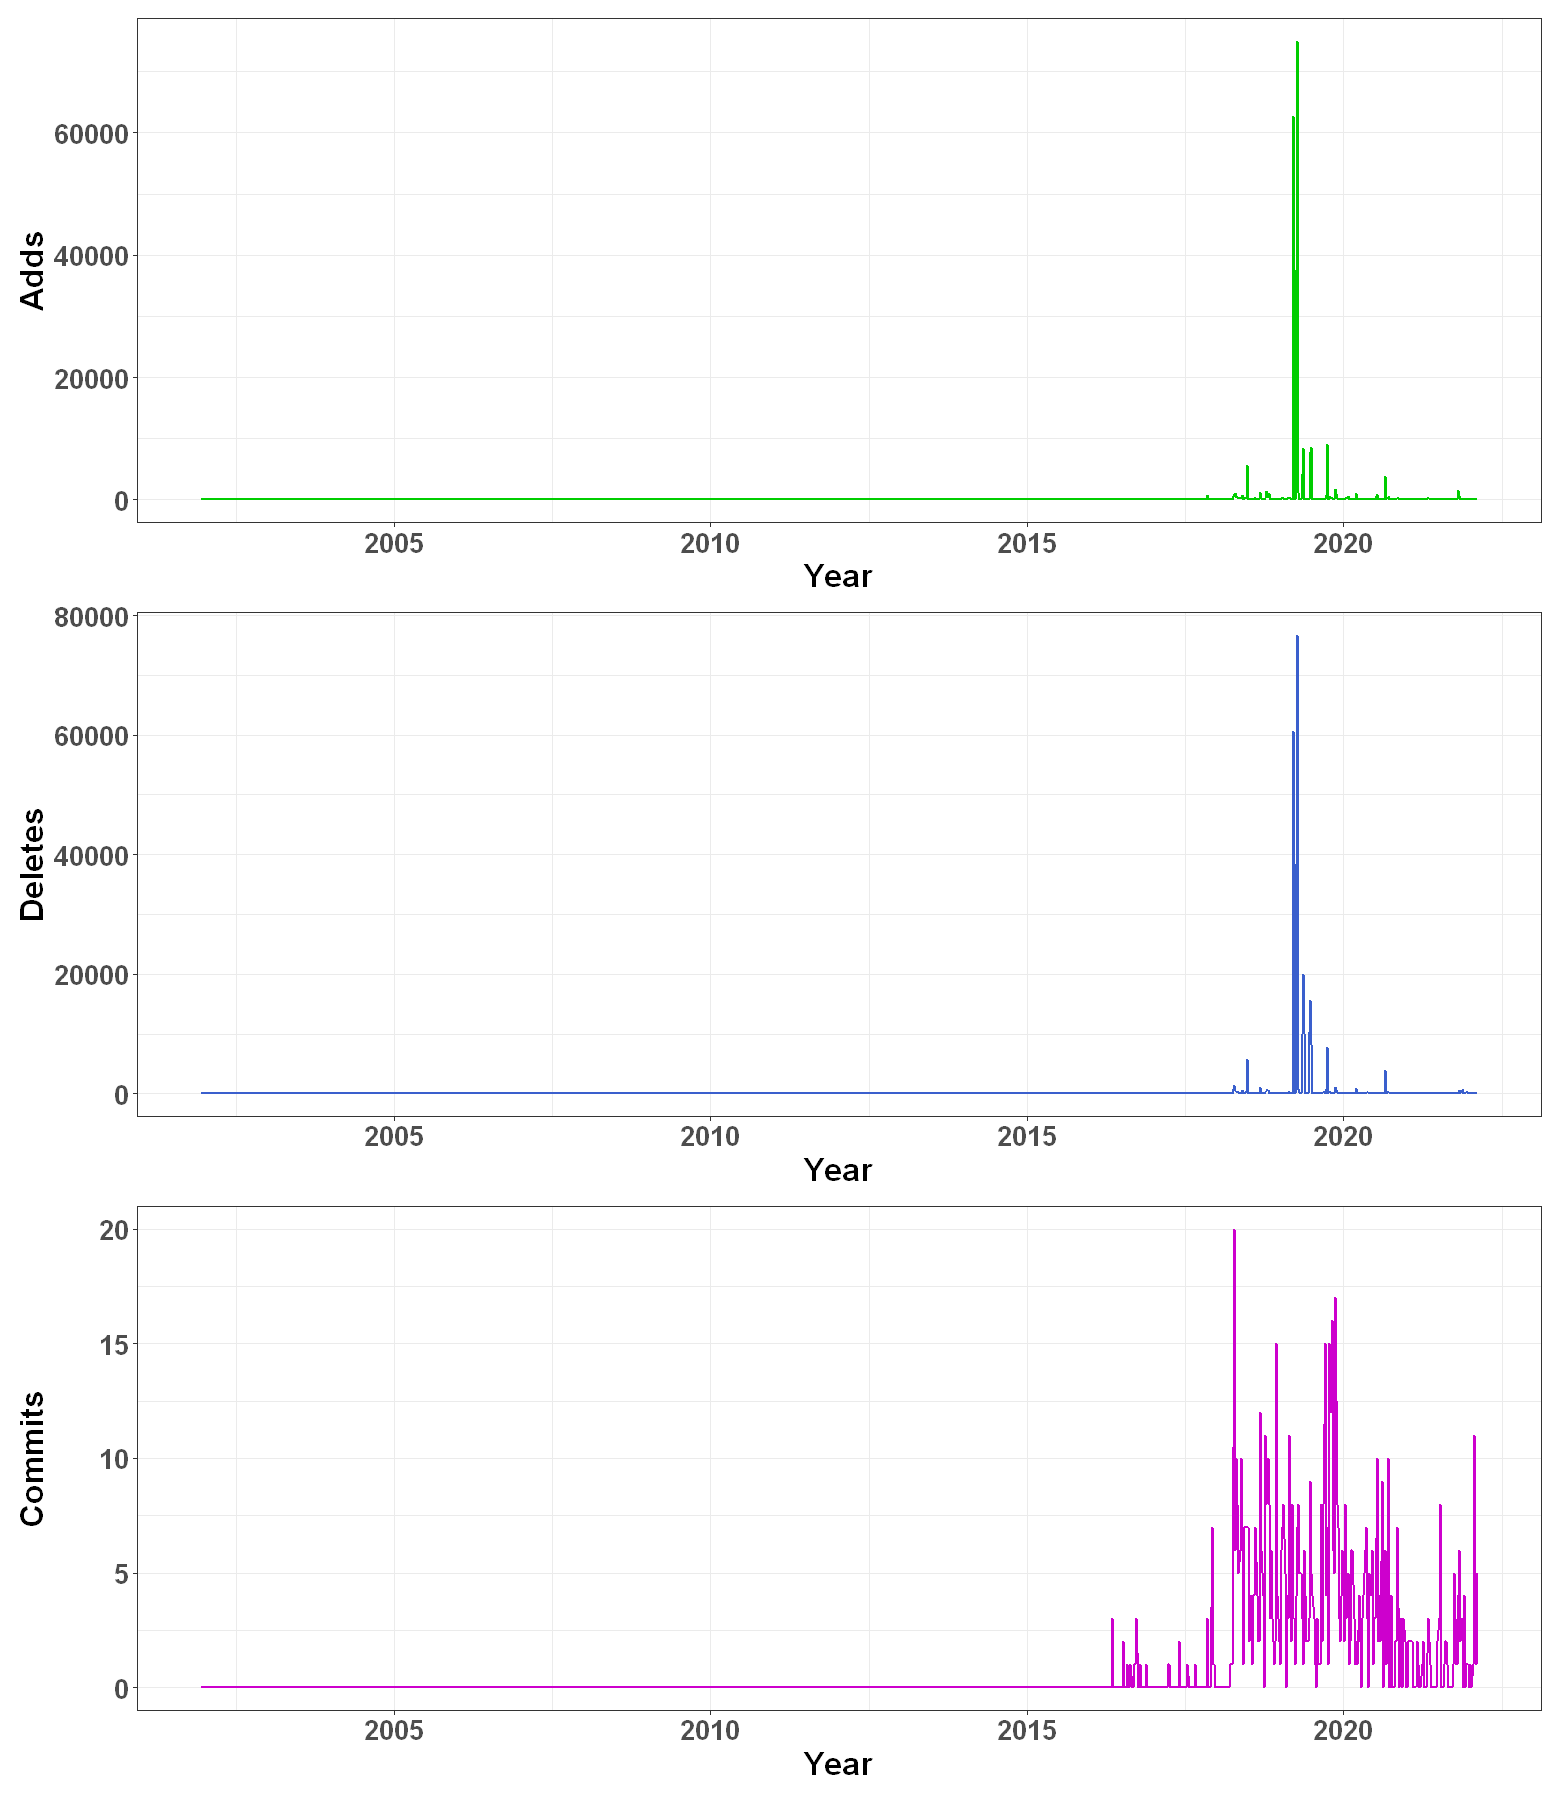

In [39]:
everything_per_user_viz(current_user)